In [1]:
#today, we will put together a lovely hovmoller raahhhhhhhhhhh
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import *
from pylab import *

import pyproj
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import shutil

# Download state and coastline data
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Set some constants for later use
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [3]:
#File path!
data_files = sorted(glob.glob('/Users/cjmasiel/Desktop/Anantha_Final/real_plane/wrfout_d02_files/wrfout_d02*'))

In [7]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


In [8]:
#now, we are interested in the 850 hPa 
index_850 = plevs.index(85000.)
index_700 = plevs.index(70000.)
print(index_850)
print(index_700)

15
24


In [9]:

w_avg = []
pv_avg = []

for item in range(len(data_files)):  # We are only interested in the 59th element of our datafiles
    ncfile = Dataset(data_files[item])
    wrf_out_data = xr.open_dataset(data_files[item])
    
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    
    #Get constant variables
    lats = getvar(ncfile, "XLAT")
    lons = getvar(ncfile, "XLONG")
    nx, ny = lats.shape
    
    ###############################################################################################
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    
    ##############################################################################################
    #Initialize subset arrays with zero values. Start with field variables, then diagnostics
    wgrd, pvor = [np.zeros([nx,ny,nlevs]) for _ in range(2)]  #Range is just the number of variables specified to the left
    
    #Get variables 
    #z = getvar(ncfile, "z")
    p = getvar(ncfile, "pressure")
    #slp = getvar(ncfile, "slp")
    #tk = getvar(ncfile, "tk")
    #ua = getvar(ncfile, "ua")
    #va = getvar(ncfile, "va")
    #rh = getvar(ncfile, "rh")
    wa  = getvar(ncfile, "wa")
    pvo = getvar(ncfile, "pvo")
    #rainc = getvar(ncfile, "RAINC")
    #rainnc = getvar(ncfile, "RAINNC")
    #psfc = getvar(ncfile, "PSFC")
    #print(va)
    
    for k in range(nlevs):
        clev = plevs[k]/100.
        yplabs[k] = clev
        ##print('interpolating to: ',clev)
        
        # Do vertical interpolation to specified pressure surfaces (in hPa)
                          #htp = interplevel(z, p, clev)
                          #uap = interplevel(ua, p, clev)
                          #vap = interplevel(va, p, clev)
        wap = interplevel(wa, p, clev)
                          #tkp = interplevel(tk, p, clev)
                          #rhp = interplevel(rh, p, clev)
        pvp = interplevel(pvo, p, clev)
    
        # Smoothing factor
        smfac = 3   # light smoothing, none for reflectivity
                    #hght[:,:,k]  = mpcalc.smooth_gaussian(htp[:,:],smfac)
                    #tmpk[:,:,k]  = mpcalc.smooth_gaussian(tkp[:,:],smfac)
                    #ugrd[:,:,k]  = mpcalc.smooth_gaussian(uap[:,:],smfac)
                    #vgrd[:,:,k]  = mpcalc.smooth_gaussian(vap[:,:],smfac)
        wgrd[:,:,k]  = wap[:,:] #mpcalc.smooth_gaussian(wap[:,:],smfac)
                    #relh[:,:,k] = mpcalc.smooth_gaussian(tkp[:,:],smfac)
        pvor[:,:,k] = pvp[:,:]
    
    #Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    #Could also set up to specify lat/lon of storm center
    binnum  = 125 #this lets us look at 500 kilometers away from the TC center
    binsize = 1
    dx      = 4000.   #Horizontal grid size of our domain
    ydist, xdist, tcdist, rlonfac   = [np.zeros([nx,ny]) for _ in range(4)]
    pvbin, wabin                    = [np.zeros([nx,ny]) for _ in range(2)]
    
    thavg = np.zeros(nlevs)
    xlabs = ['']*binnum
    pvazavg, waazavg= [np.zeros([nlevs-1,int(binnum/binsize)]) for _ in range(2)]

    #define storm center
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    # compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*cos(d2r*lats[:,:])
    ydist[:,:]   = (lats[:,:] - lats[ypos,xpos])*111000
    xdist[:,:]   = (lons[:,:] - (lons[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    #windabs[:,:,:] = sqrt(ugrd[:,:,:]**2 + vgrd[:,:,:]**2)
    
#     for k in range (0,nlevs):
#         print("The number loop we are in is", k)
#         thavg[k] = np.nanmean(thta[:,:,k])
#         for i in range (0,nx):
#             for j in range (0,ny):
#                 theta_ang[i,j] = math.atan2(ydist[i,j],xdist[i,j])
#                 #u_radial[i,j,k] = ugrd[i,j,k]*math.cos(theta_ang[i,j]) + vgrd[i,j,k]*math.sin(theta_ang[i,j])
#                 v_azimuth[i,j,k] = -ugrd[i,j,k]*sin(theta_ang[i,j]) + vgrd[i,j,k]*cos(theta_ang[i,j]) 
#                 #momentum[i,j,k] = tcdist[i,j] * v_azimuth[i,j,k] + (1/2) * f[i,j] * (tcdist[i,j]**2)
    
    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        
        xlabs[j] = str(bincnt*12)
        for k in range (1, nlevs-1):
            pvbin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), pvor[:,:,k], nan)
            wabin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), wgrd[:,:,k], nan)
            
            pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
            waazavg[k,bincnt] = np.nanmean(wabin[:,:])
    
    #now, we want to find the 850-700 PV
    mid_level_PV = np.mean(pvazavg[index_850:index_700,:], axis=0)
    #print(mid_level_PV)
    
    #append to list we will utilize for hovmollers!
    pv_avg.append(mid_level_PV)
    w_avg.append(waazavg[index_700, :])

WRF valid time:  2007-08-18_00 2007-08-18 00:00 2007-08-18T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_03 2007-08-18 03:00 2007-08-18T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_06 2007-08-18 06:00 2007-08-18T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_09 2007-08-18 09:00 2007-08-18T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_12 2007-08-18 12:00 2007-08-18T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_15 2007-08-18 15:00 2007-08-18T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_18 2007-08-18 18:00 2007-08-18T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-18_21 2007-08-18 21:00 2007-08-18T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_00 2007-08-19 00:00 2007-08-19T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_03 2007-08-19 03:00 2007-08-19T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_06 2007-08-19 06:00 2007-08-19T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_09 2007-08-19 09:00 2007-08-19T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_12 2007-08-19 12:00 2007-08-19T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_15 2007-08-19 15:00 2007-08-19T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_18 2007-08-19 18:00 2007-08-19T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-19_21 2007-08-19 21:00 2007-08-19T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_00 2007-08-20 00:00 2007-08-20T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_03 2007-08-20 03:00 2007-08-20T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_06 2007-08-20 06:00 2007-08-20T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_09 2007-08-20 09:00 2007-08-20T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_12 2007-08-20 12:00 2007-08-20T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_15 2007-08-20 15:00 2007-08-20T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_18 2007-08-20 18:00 2007-08-20T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-20_21 2007-08-20 21:00 2007-08-20T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_00 2007-08-21 00:00 2007-08-21T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_03 2007-08-21 03:00 2007-08-21T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_06 2007-08-21 06:00 2007-08-21T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_09 2007-08-21 09:00 2007-08-21T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_12 2007-08-21 12:00 2007-08-21T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_15 2007-08-21 15:00 2007-08-21T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_18 2007-08-21 18:00 2007-08-21T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-21_21 2007-08-21 21:00 2007-08-21T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_00 2007-08-22 00:00 2007-08-22T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_03 2007-08-22 03:00 2007-08-22T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_06 2007-08-22 06:00 2007-08-22T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_09 2007-08-22 09:00 2007-08-22T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_12 2007-08-22 12:00 2007-08-22T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_15 2007-08-22 15:00 2007-08-22T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_18 2007-08-22 18:00 2007-08-22T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-22_21 2007-08-22 21:00 2007-08-22T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_00 2007-08-23 00:00 2007-08-23T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_03 2007-08-23 03:00 2007-08-23T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_06 2007-08-23 06:00 2007-08-23T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_09 2007-08-23 09:00 2007-08-23T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_12 2007-08-23 12:00 2007-08-23T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_15 2007-08-23 15:00 2007-08-23T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_18 2007-08-23 18:00 2007-08-23T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-23_21 2007-08-23 21:00 2007-08-23T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_00 2007-08-24 00:00 2007-08-24T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_03 2007-08-24 03:00 2007-08-24T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_06 2007-08-24 06:00 2007-08-24T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_09 2007-08-24 09:00 2007-08-24T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_12 2007-08-24 12:00 2007-08-24T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_15 2007-08-24 15:00 2007-08-24T15:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_18 2007-08-24 18:00 2007-08-24T18:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-24_21 2007-08-24 21:00 2007-08-24T21:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-25_00 2007-08-25 00:00 2007-08-25T00:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-25_03 2007-08-25 03:00 2007-08-25T03:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-25_06 2007-08-25 06:00 2007-08-25T06:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-25_09 2007-08-25 09:00 2007-08-25T09:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


WRF valid time:  2007-08-25_12 2007-08-25 12:00 2007-08-25T12:00:00.000000000


/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:133: RuntimeWarning: Mean of empty slice
  pvazavg[k,bincnt] = np.nanmean(pvbin[:,:])
/var/folders/vh/tg2m9q6x4z92ns7xk0s1gfdm0000gt/T/ipykernel_11772/2933961867.py:134: RuntimeWarning: Mean of empty slice
  waazavg[k,bincnt] = np.nanmean(wabin[:,:])


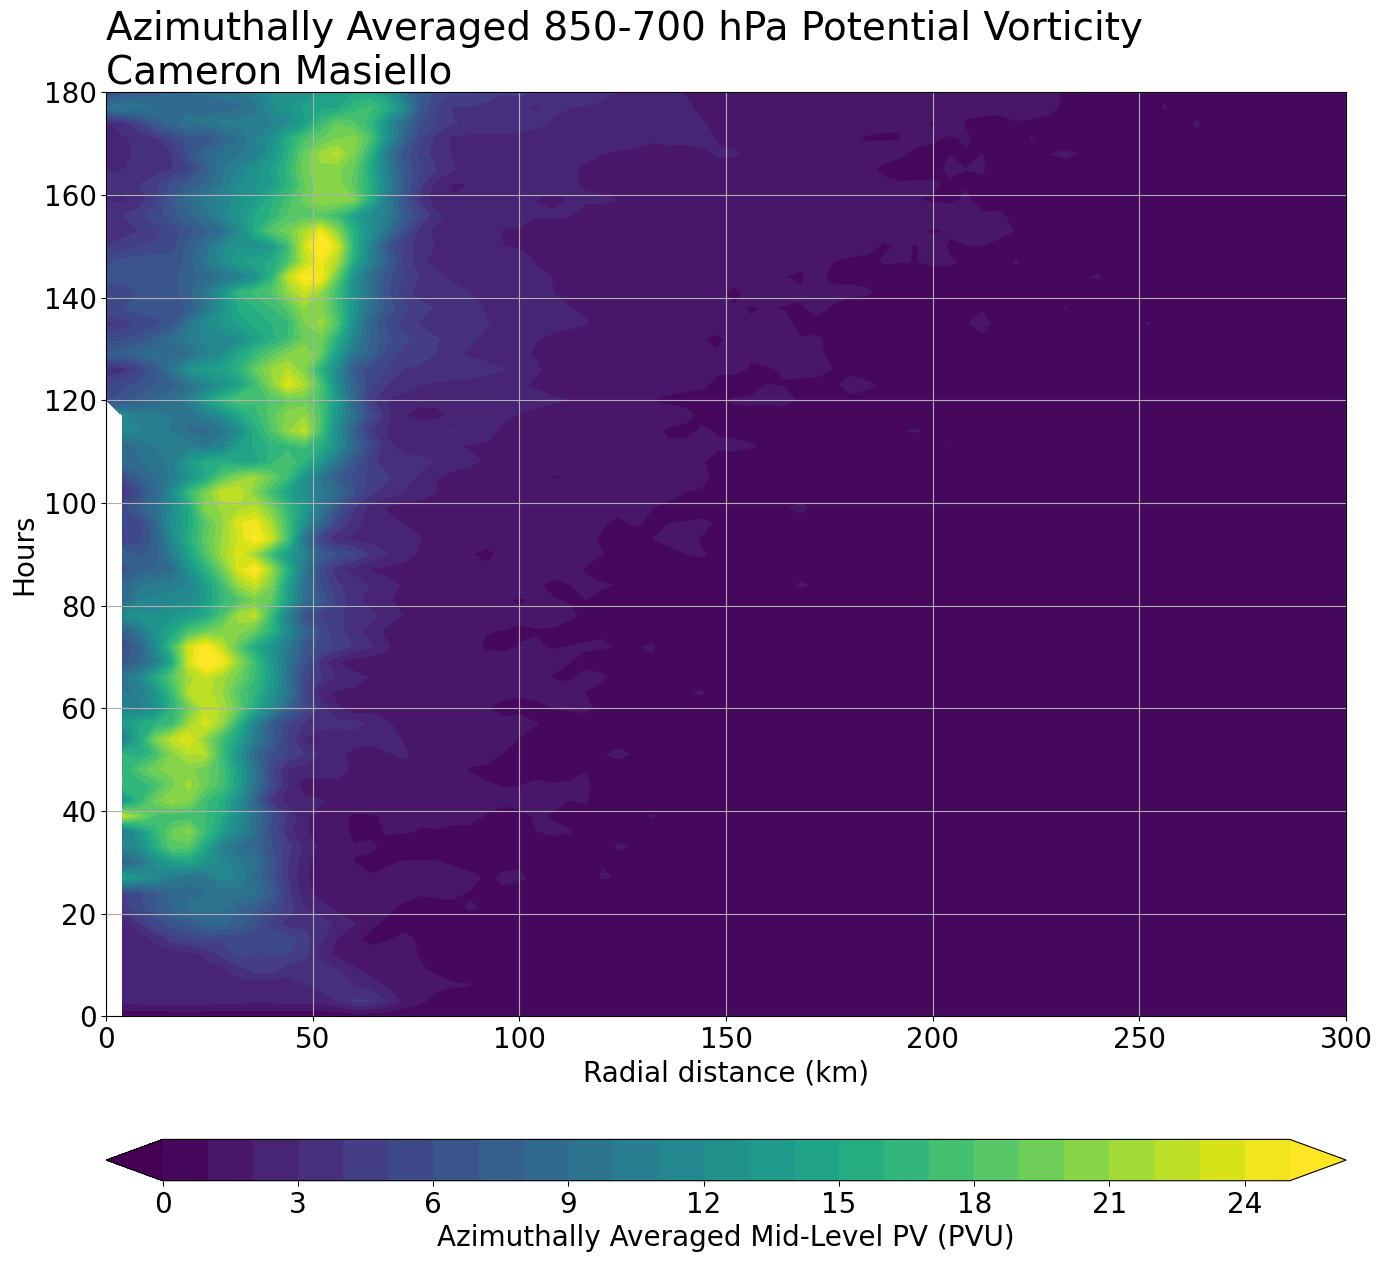

In [20]:
######################################################################################################
#Here, we now plot our hovmoller!

#Define the levels you want for the contours
levels = np.arange(0, 26, 1)

#Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 16))

#If each grid space represents 4 km, create an array that reflects the actual distance
radial_distance = np.arange(0, binnum*4, 4)  # This assumes binnum grid cells, 4 km apart

#If each grid space represents 3 hrs, create an array that reflects the actual time
time = np.arange(0, len(pv_avg)*3, 3)  # This assumes binnum grid cells, 3 hours apart

#Create the contourf plot with the specified levels
contourf_plot = ax.contourf(radial_distance, time, pv_avg, levels=levels, 
                            cmap='viridis', origin='lower', extend = 'both')

cbar = plt.colorbar(contourf_plot, orientation = 'horizontal', 
                    pad = .1, shrink = 1, aspect = 30, extend = 'both')

cbar.ax.tick_params(labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

cbar.ax.set_xlabel('Azimuthally Averaged Mid-Level PV (PVU)', fontsize = 20)
ax.grid(True)

#Set axis labels and title
ax.set_xlabel('Radial distance (km)', fontsize=20)
ax.set_ylabel('Hours', fontsize=20)
ax.set_title('Azimuthally Averaged 850-700 hPa Potential Vorticity\nCameron Masiello', loc = 'left', fontsize=28)

#Set the axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, time.max())
ax.grid(True)

plt.show()

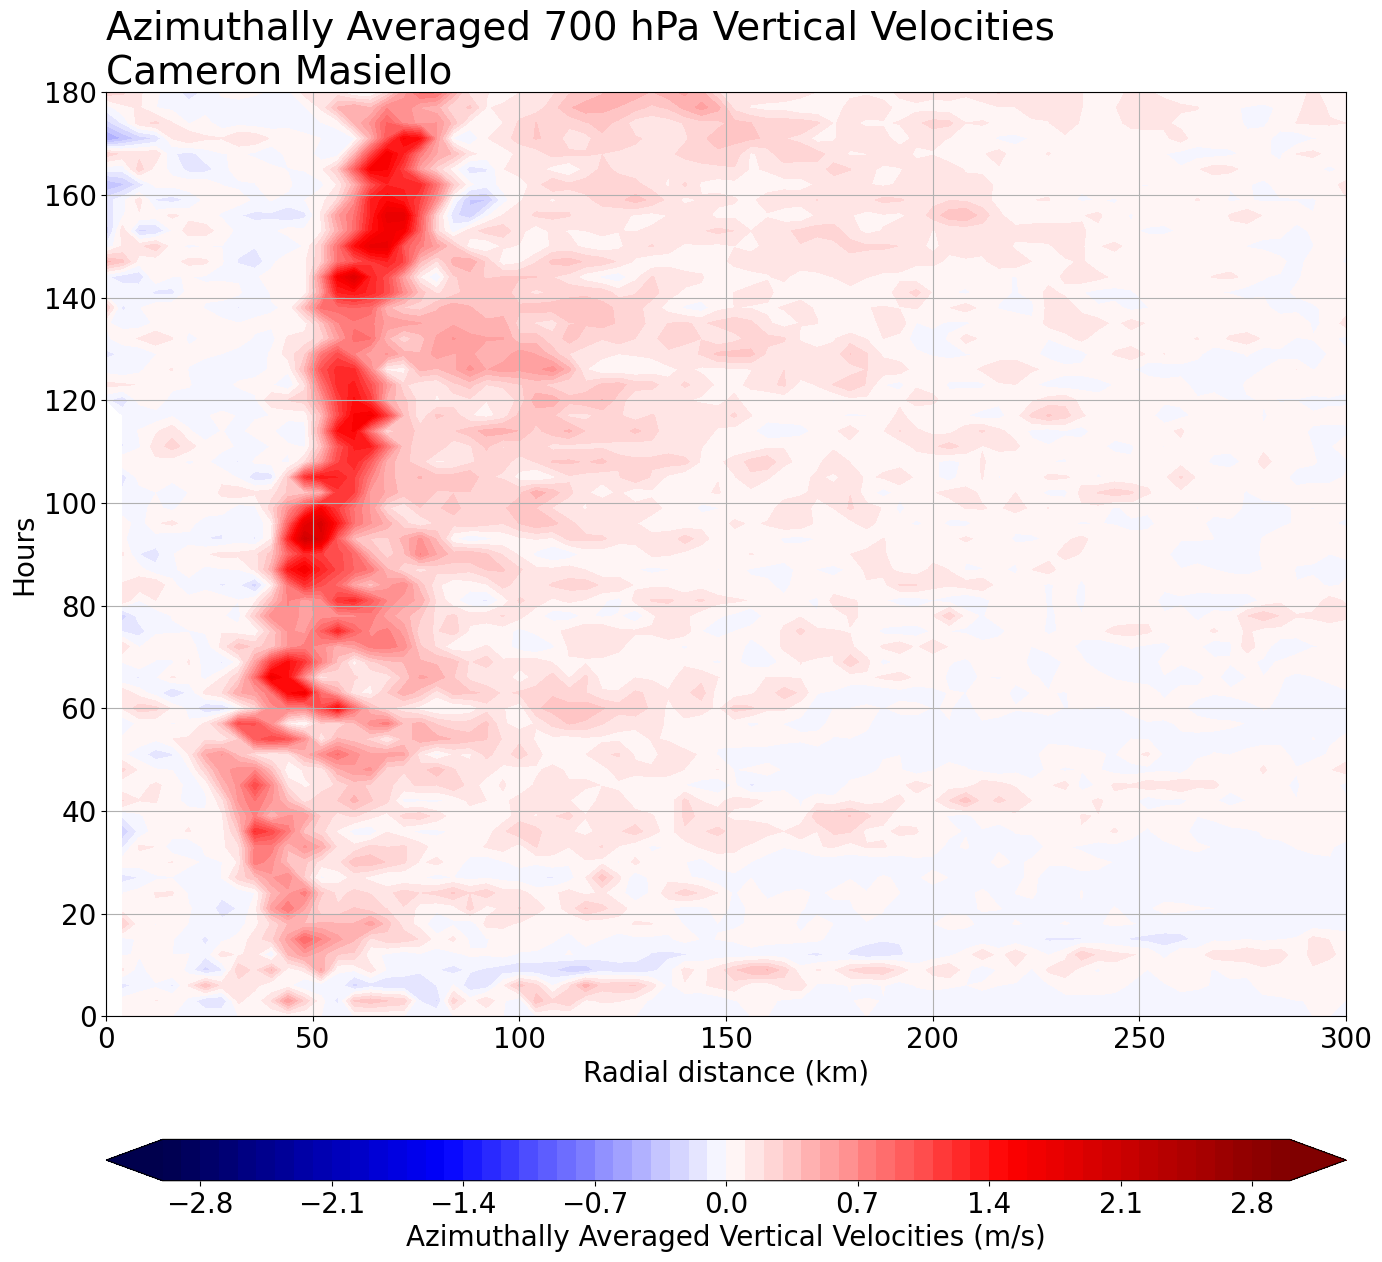

In [25]:
#Here, we now plot our hovmoller!

#Define the levels you want for the contours
levels = np.arange(-3, 3.1, .1)

#Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 16))

#If each grid space represents 4 km, create an array that reflects the actual distance
radial_distance = np.arange(0, binnum*4, 4)  # This assumes binnum grid cells, 4 km apart

#If each grid space represents 3 hrs, create an array that reflects the actual time
time = np.arange(0, len(pv_avg)*3, 3)  # This assumes binnum grid cells, 3 hours apart

#Create the contourf plot with the specified levels
contourf_plot = ax.contourf(radial_distance, time, w_avg, levels=levels, 
                            cmap='seismic', origin='lower', extend = 'both')

cbar = plt.colorbar(contourf_plot, orientation = 'horizontal', 
                    pad = .1, shrink = 1, aspect = 30, extend = 'both')

cbar.ax.tick_params(labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

cbar.ax.set_xlabel('Azimuthally Averaged Vertical Velocities (m/s)', fontsize = 20)
ax.grid(True)

#Set axis labels and title
ax.set_xlabel('Radial distance (km)', fontsize=20)
ax.set_ylabel('Hours', fontsize=20)
ax.set_title('Azimuthally Averaged 700 hPa Vertical Velocities\nCameron Masiello', loc = 'left', fontsize=28)

#Set the axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, time.max())
ax.grid(True)

plt.show()